In [2]:
# Set these Global prams
batch_sz = 18
num_epochs = 50
model_name = 'densenet'
rerun=0
pat = 10 #patience
num_classes = 3
input_shape_tup = (128, 128, 3)
reshape_tup = (128, 128)

In [3]:
# DATA MANIPULATION
import numpy as np  
import pandas as pd 

# VISUALIZATION
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# MISC
import os
import cv2
import warnings
warnings.filterwarnings('ignore')
# import dicom to read the images, you may need to do: pip install pydicom
import pydicom as dicom

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
df1 = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')

In [5]:
df1['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [6]:
df1.drop_duplicates(inplace=True)

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26684 entries, 0 to 30225
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  26684 non-null  object
 1   class      26684 non-null  object
dtypes: object(2)
memory usage: 625.4+ KB


In [8]:
df1['class'].value_counts()

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

<AxesSubplot: xlabel='class', ylabel='count'>

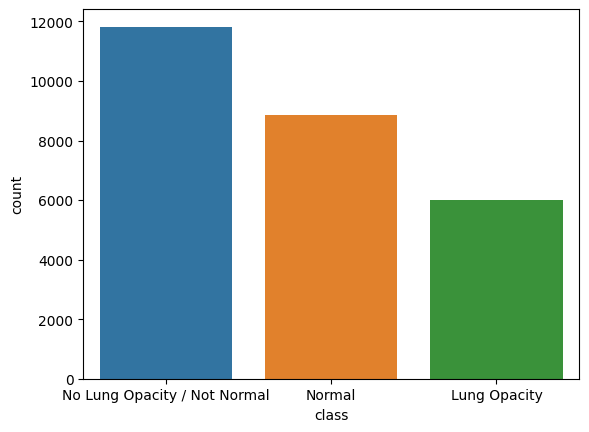

In [9]:
sns.countplot(x='class', data=df1)

In [10]:
classes = df1['class'].unique()
print(classes)

['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


In [11]:
# We try to balance the dataset. Since we have many images (26.7kimages) and the length of lowest numbered class is 6012,
# we try to reduce each class to have 5000 images.
import random
np.random.seed(10)
df = pd.DataFrame(columns=['patientId','class'])
for cl in classes:
    df2 = df1[df1['class']==cl]
    n_remove = len(df2)-5000
    df2 = df2.sample(len(df2)-n_remove)
    print(df2.shape)
    df = df.append(df2,verify_integrity=True)
print(df.shape)
df = df.sort_index()
df.head()

(5000, 2)
(5000, 2)
(5000, 2)
(15000, 2)


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
10,008c19e8-a820-403a-930a-bc74a4053664,No Lung Opacity / Not Normal


In [12]:
df['class'].value_counts()

No Lung Opacity / Not Normal    5000
Normal                          5000
Lung Opacity                    5000
Name: class, dtype: int64

<AxesSubplot: xlabel='class', ylabel='count'>

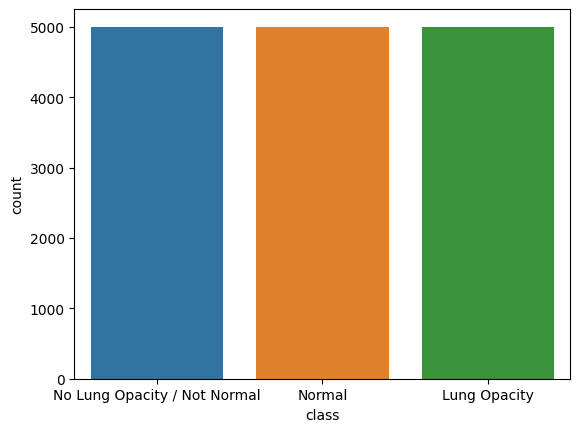

In [13]:
sns.countplot(x='class',data=df)

In [14]:
#store rows that we removed into another dataframe that can be used for testing
df_t = df1[~df1.isin(df)].dropna()
df_t['class'].value_counts()

No Lung Opacity / Not Normal    6821
Normal                          3851
Lung Opacity                    1012
Name: class, dtype: int64

In [15]:
# Now we get 1000 rows of each class and form the testing data.
#min(df2['class'].value_counts())
import random
np.random.seed(10)
df_test = pd.DataFrame(columns=['patientId','class'])
for cl in classes:
    df2 = df_t[df_t['class']==cl]
    n_remove = len(df2)-1000
    df2 = df2.sample(len(df2)-n_remove)
    print(df2.shape)
    df_test = df_test.append(df2,verify_integrity=True)
print(df_test.shape)
df_test = df_test.sort_index()
df_test.head()

(1000, 2)
(1000, 2)
(1000, 2)
(3000, 2)


,patientId,class
18,00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b,No Lung Opacity / Not Normal
41,01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce,Lung Opacity
55,01c0b605-0a82-401b-9649-81252304ac45,Normal
57,01cad8d0-45cd-4603-b099-94055d322310,Lung Opacity
92,020a16e3-baf9-4cf0-859c-c79b5253d717,Lung Opacity


In [16]:
#store rows that we removed for testing
df5 = df_t[~df_t.isin(df_test)].dropna()
cls_count = []
for i in range(0,num_classes):
    cls_count.append(df5['class'].value_counts()[i])
print(cls_count)

[5821, 2851, 12]


In [17]:
# We try create another dataset will all remaining unused + some from previous samples.
import random
np.random.seed(10)
df_new = pd.DataFrame(columns=['patientId','class'])
j=0
for cl in classes:
    df2 = df[df['class']==cl]
    n_remove = len(df2)-(5000-min(cls_count[j],5000))
    df2 = df2.sample(len(df2)-n_remove)
    print(df2.shape)
    df_new = df_new.append(df2,verify_integrity=True)
    j+=1
df_new = df_new.append(df5,verify_integrity=True)
print(df_new.shape)
df_new = df_new.sort_index()
df_new.head()

(0, 2)
(2149, 2)
(4988, 2)
(15821, 2)


,patientId,class
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal


In [18]:
df_new['class'].value_counts()

No Lung Opacity / Not Normal    5821
Normal                          5000
Lung Opacity                    5000
Name: class, dtype: int64

In [19]:
X = df['patientId']
Y = df['class']
x_test = df_test['patientId']
y_test = df_test['class']
x0 = df_new['patientId']
y0 = df_new['class']

In [20]:
# Split the dataset into 4 sets for easier loading and avoiding memory errors, maintaining the same 'class' ratios.
# The idea is we train the model on each set separately and at the end store the weights. Load the weights back before training the next set.
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, stratify = Y, test_size = 0.5, random_state =42)
x1, x2, y1, y2 = train_test_split(x_train, y_train, stratify = y_train, test_size = 0.5, random_state =42)
x3, x4, y3, y4 = train_test_split(x_val, y_val, stratify = y_val, test_size = 0.5, random_state =42)

In [21]:
print(x0.shape,y0.shape)
print(x1.shape,y1.shape)
print(x2.shape,y2.shape)
print(x3.shape,y3.shape)
print(x4.shape,y4.shape)

(15821,) (15821,)
(3750,) (3750,)
(3750,) (3750,)
(3750,) (3750,)
(3750,) (3750,)


In [22]:
del X, Y
del df1, df2, df_t, df, df5, df_new, df_test
del x_train, x_val, y_train, y_val

In [23]:
import gc
gc.collect()

15

In [24]:
# Now we need to replace the x? datasets that has patiendId with their corresponding actual images/pixel data. 
# We do this by defining a function
def populate_X_images(x):
    os.chdir('/kaggle/input/rsna-pneumonia-detection-challenge/')
    file_path='stage_2_train_images'
    x_img = pd.DataFrame(columns=['image'])
    for Id in x:
        fname = str(Id) + ".dcm"
        ds = dicom.dcmread(os.path.join(file_path,fname))
        x_img = x_img.append({'image':ds.pixel_array},ignore_index=True)
    return x_img

def populate_X_test_images():
    os.chdir('/kaggle/input/rsna-pneumonia-detection-challenge/')
    file_path='stage_2_test_images'
    x_img = pd.DataFrame(columns=['image'])
    for fname in os.listdir(file_path):
        ds = dicom.dcmread(os.path.join(file_path,fname))
        x_img = x_img.append({'image':ds.pixel_array},ignore_index=True)
    return x_img

# Define a new function to resize and reshape according to our needs
import cv2
def resize_reshape_x(x, shape: tuple):
    X_rsz = []
    for i in (x['image']):
        img = cv2.resize(i, shape)
        img = np.stack((img,)*3, axis=-1)
        X_rsz.append(img)
    return np.array(X_rsz)

# Vizualizing the images
def plot_sample(x,y):
    plt.figure(figsize=(20,20))
    n=3
    j=1
    sample = random.sample(range(0,len(x)),3)
    for i in sample:
        plt.subplot(1,n,j)
        plt.imshow(x[i])
        plt.title("{}".format(y.iloc[i]))
        j+=1
# pre-process data
def pre_process(x_tr, x_val, y_tr, y_val):
    x_tr = (x_tr/255).astype('float16')
    y_tr = pd.get_dummies(y_tr)
    x_val = (x_val/255).astype('float16')
    y_val = pd.get_dummies(y_val)
    return x_tr, x_val, y_tr, y_val

def pre_process_test(x_test, y_test):
    x_test = (x_test/255).astype('float16')
    y_test = pd.get_dummies(y_test)
    return x_test, y_test

# Loading the images, replacing the patientIds. Also resize them to required,shape
def load_image(x):
    x_img = populate_X_images(x)
    print('Populated Images\n')
    x_img = resize_reshape_x(x_img,reshape_tup)
    return x_img

In [25]:
def create_model():
    import tensorflow as tf
    from tensorflow.keras.applications import ResNet50V2
    from tensorflow.keras.layers import Dense, AveragePooling2D, Dropout, Conv2D, Flatten, Activation, MaxPooling2D, concatenate, Input, BatchNormalization
    from tensorflow.keras.models import Model, Sequential
    input_x = tf.keras.Input(shape=input_shape_tup,name='inputx')
    base_model = ResNet50v2(input_tensor=input_x,
                          weights='imagenet',
                          #pooling='max',
                          include_top=False) 
    # Uncomment the below if you want to make few last layers of the base model trainable
    #for layer in base_model.layers[0:-31]: # has 201 layers in total
    #    layer.trainable = False
    base_model.trainable = False
    x = base_model.output
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(512, activation='relu',trainable=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(256, activation='relu',trainable=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(128, activation='relu',trainable=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    preds = Dense(3, activation='softmax')(x) #final layer with softmax activation

    output_model = Model(base_model.input,
                         outputs=preds)

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001) #reduce lr on re-run when loading previous weights.
    output_model.compile(optimizer=opt,
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

    #output_model.summary() # uncomment if you want to see the summary of the model
    return output_model

In [26]:
# function to plot Accuracy and loss plots
def plot_hist(tr_hist):
    accuracy = tr_hist.history['accuracy']
    val_accuracy = tr_hist.history['val_accuracy']
    loss = tr_hist.history['loss']
    val_loss = tr_hist.history['val_loss']
    epochs   = range(len(accuracy)) # Get number of epochs

    plt.plot  (epochs, accuracy, label = 'training accuracy')
    plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
    plt.title ('Training and validation accuracy')
    plt.legend(loc = 'lower right')
    plt.figure()

    plt.plot  (epochs, loss, label = 'training loss')
    plt.plot  (epochs, val_loss, label = 'validation loss')
    plt.legend(loc = 'upper right')
    plt.title ('Training and validation loss')

def plot_hist_simple(tr_hist):
    pd.DataFrame(tr_hist).plot()

In [27]:
# Saving model and training history and its weights for future use
import pickle
def save_model_and_hist(model, hist, model_file, model_wght_file, hist_file):
    model.save(model_file)
    model.save_weights(model_wght_file)
    with open(hist_file, 'wb') as file_pi:
        pickle.dump(hist.history, file_pi)

# Load hist and plot
def load_and_plot_hist(model_name: str, i: int):
    hist_fname = "/kaggle/working/"+ model_name + "_hist" + str(i)
    with open(hist_fname, 'rb') as f:
        tr_hist = pickle.load(f)
    pd.DataFrame(tr_hist).plot()

# Load and return model
from tensorflow.keras.models import load_model
def load_and_return_model(modelname: str, j: int):
    model_fname = '/kaggle/working/'+ modelname + str(j) + ".h5"
    model = load_model(model_fname)
    return model

In [28]:
import gc
gc.collect()

53

In [29]:
import tensorflow.keras.callbacks as cb
def run_save_one_iteration(x_img, y, model, bsz, epo, modelname: str, j: int):
    #plot_sample(x_img, y)
    x_train, x_val, y_train, y_val = train_test_split(x_img, y, stratify = y, test_size = 0.2, random_state =42)
    x_train, x_val, y_train, y_val = pre_process(x_train, x_val, y_train, y_val)
    print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)
    callback = cb.EarlyStopping(monitor='val_loss', patience = pat,restore_best_weights=True)
    tr_history = model.fit(x=x_train,
                           y=y_train,
                           batch_size=bsz,
                           epochs=epo, 
                           validation_data=(x_val , y_val),
                           callbacks=callback
                           )
    #plot_hist_sample(tr_history)
    model_fname = '/kaggle/working/' + modelname + str(j) + ".h5"
    model_wname = '/kaggle/working/' + modelname + "_weights" + str(j) + ".h5"
    model_hname= '/kaggle/working/' + modelname + "_hist" + str(j)
    save_model_and_hist(model, tr_history, model_fname, model_wname, model_hname)
    del x_train, x_val, y_train, y_val, tr_history

In [30]:
from tensorflow.keras.utils import plot_model
from keras import backend as K
model = create_model()
old=model.optimizer.learning_rate
# When Re-running, we load weights of the previous run and reduce the learning rate before we run again.
if rerun==True: 
    print(old)
    new=(old/5)
    K.set_value(model.optimizer.learning_rate, new)
    new=model.optimizer.learning_rate
    print(new)
    old = new
    model_wname = '/kaggle/working/'+model_name+'_weights4.h5'
    #model_wname = "/kaggle/input/densenet-weights/densenet_weights4 (1).h5"
    ## Uncomment this when re-running after 1 full run, to load the weights of previous run.
    model.load_weights(model_wname)

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
for j in range(0,5):
    gc.collect()
    x_img = load_image(globals()['x'+str(j)])
    gc.collect()
    run_save_one_iteration(x_img, globals()['y'+str(j)], model, batch_sz, num_epochs, model_name, j)
    gc.collect()
    load_and_plot_hist(model_name,j)
    del x_img, model
    gc.collect()
    model= load_and_return_model(model_name, j)

In [ ]:
# Now use the model to predict outcomes for Test dataset
gc.collect()
if rerun==False:
    x_img = load_image(x_test)
    x_test, y_test = pre_process_test(x_img, y_test)
gc.collect()
y_pred = model.predict(x_test,batch_size=batch_sz)

In [ ]:
# Print the confusion metrics
from sklearn.metrics import confusion_matrix
gc.collect()
y_pred_label = y_pred.argmax(axis=1)
y_test_label = y_test.to_numpy().argmax(axis=1)
cm = confusion_matrix(y_test_label, y_pred_label)
print(y_test.columns)
print(cm)

In [ ]:
#Print the Precision, Recall, F1-scores etc.
from sklearn.metrics import classification_report
print(classification_report(y_test_label, y_pred_label))

In [ ]:
del cm, y_test_label, y_pred_label
gc.collect()

In [ ]:
# Evaluate and Print Model performance on Test dataset
loss, acc = model.evaluate(x_test, y_test, batch_size=18)
print("Model loss: %.2f" % (loss*100))
print("Model Accuracy: %.2f" % (acc*100))

In [ ]:
import os
os.listdir('/kaggle/working/')

In [ ]:
os.chdir('/kaggle/working/')
!zip -r file1.zip /kaggle/working/*.h5

In [ ]:
from IPython.display import FileLink
FileLink(r'file1.zip') #Click on the link that appears in the output to download a zip file containing all output files.

In [ ]:
rerun=True

In [ ]:
plot_model(model,model_name+"_model.png",show_shapes=True)

In [ ]:
ls